In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from scipy import stats
import numpy.ma as ma
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import seaborn as sns
# %matplotlib inline

In [2]:
names=['year', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
df1 = pd.read_csv('/home/sbarc/students/nash/data/teleconnection_indices/dmi.monthly_indianoceandipole.txt',
                delim_whitespace=True, engine='python', header=0, names=names, skiprows=1, skipfooter=7,
                na_values='-999.0')

df = pd.melt(df1, id_vars=['year'], var_name='month', value_name='anom')
df = df.sort_values(by=['year', 'month'])
df['time'] = pd.date_range('1871-01', '2018-12', freq='1MS')

df['COND'] = 'NEUTRAL'
df.loc[df['anom']>0, 'COND'] = 'POSITIVE'
df.loc[df['anom']<0, 'COND'] = 'NEGATIVE'
df = df.loc[df['year'] >= 1980]
IOD_df = df.loc[(df['month'] == '12') | (df['month'] == '03') | (df['month'] == '06') | (df['month'] == '09')]
IOD_df

,year,month,anom,time,COND
405,1980,03,-0.251,1980-03-01,NEGATIVE
849,1980,06,-0.171,1980-06-01,NEGATIVE
1293,1980,09,-0.350,1980-09-01,NEGATIVE
1737,1980,12,-0.264,1980-12-01,NEGATIVE
406,1981,03,0.186,1981-03-01,POSITIVE
850,1981,06,-0.032,1981-06-01,NEGATIVE
1294,1981,09,-0.363,1981-09-01,NEGATIVE
1738,1981,12,0.211,1981-12-01,POSITIVE
407,1982,03,0.218,1982-03-01,POSITIVE
851,1982,06,0.460,1982-06-01,POSITIVE


In [3]:
def ar_climatology(dataarray, threshold):
    mask = dataarray.where(dataarray >= threshold).dropna(dim='time')
    mask = mask.resample(time='1D').mean()
    day_list = mask.dropna(dim='time').time
    monthly_count = mask.resample(time='1MS').count()
    season_count = mask.resample(time='QS-DEC').count()
    climatology_count = mask.groupby('time.month').count('time')
                           
    return day_list, monthly_count, season_count, climatology_count

filename = '/home/sbarc/students/nash/data/CH1_generated_data/ar_catalog_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

R01_dates, R01_monthct, R01_season, R01_clim = ar_climatology(ds.R01, 0.3)
R02_dates, R02_monthct, R02_season, R02_clim = ar_climatology(ds.R02, 0.3)
R03_dates, R03_monthct, R03_season, R03_clim = ar_climatology(ds.R03, 0.3)

In [4]:
ar_df = pd.concat([R01_season.to_dataframe(), 
                   R02_season.to_dataframe(),
                   R03_season.to_dataframe()], axis=1)
ar_df = ar_df.drop(columns=['lev', 'ens'])
ar_df.loc[:,"time"] = ar_df.index
ar_df['total'] = ar_df['R01'] + ar_df['R02'] + ar_df['R03']
ar_df = ar_df.loc[(ar_df.index.year >= 1980) & (ar_df.index.year <= 2018)]
# ar_df

## join IOD df and ar df
IOD_df['time'] = ar_df.index
new_df = ar_df.join(IOD_df.set_index('time'))


DJF = new_df.loc[new_df.index.month == 12]
MAM = new_df.loc[new_df.index.month == 3]
JJA = new_df.loc[new_df.index.month == 6]
SON = new_df.loc[new_df.index.month == 9]

/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
new_df

,R01,R02,R03,time,total,year,month,anom,COND
time,,,,,,,,,
1980-03-01,18,5,5,1980-03-01,28,1980,03,-0.251,NEGATIVE
1980-06-01,0,19,28,1980-06-01,47,1980,06,-0.171,NEGATIVE
1980-09-01,1,1,5,1980-09-01,7,1980,09,-0.350,NEGATIVE
1980-12-01,10,6,5,1980-12-01,21,1980,12,-0.264,NEGATIVE
1981-03-01,17,3,7,1981-03-01,27,1981,03,0.186,POSITIVE
1981-06-01,3,16,15,1981-06-01,34,1981,06,-0.032,NEGATIVE
1981-09-01,2,5,7,1981-09-01,14,1981,09,-0.363,NEGATIVE
1981-12-01,8,9,9,1981-12-01,26,1981,12,0.211,POSITIVE
1982-03-01,12,5,11,1982-03-01,28,1982,03,0.218,POSITIVE


./results/IOD_AR_freq.png


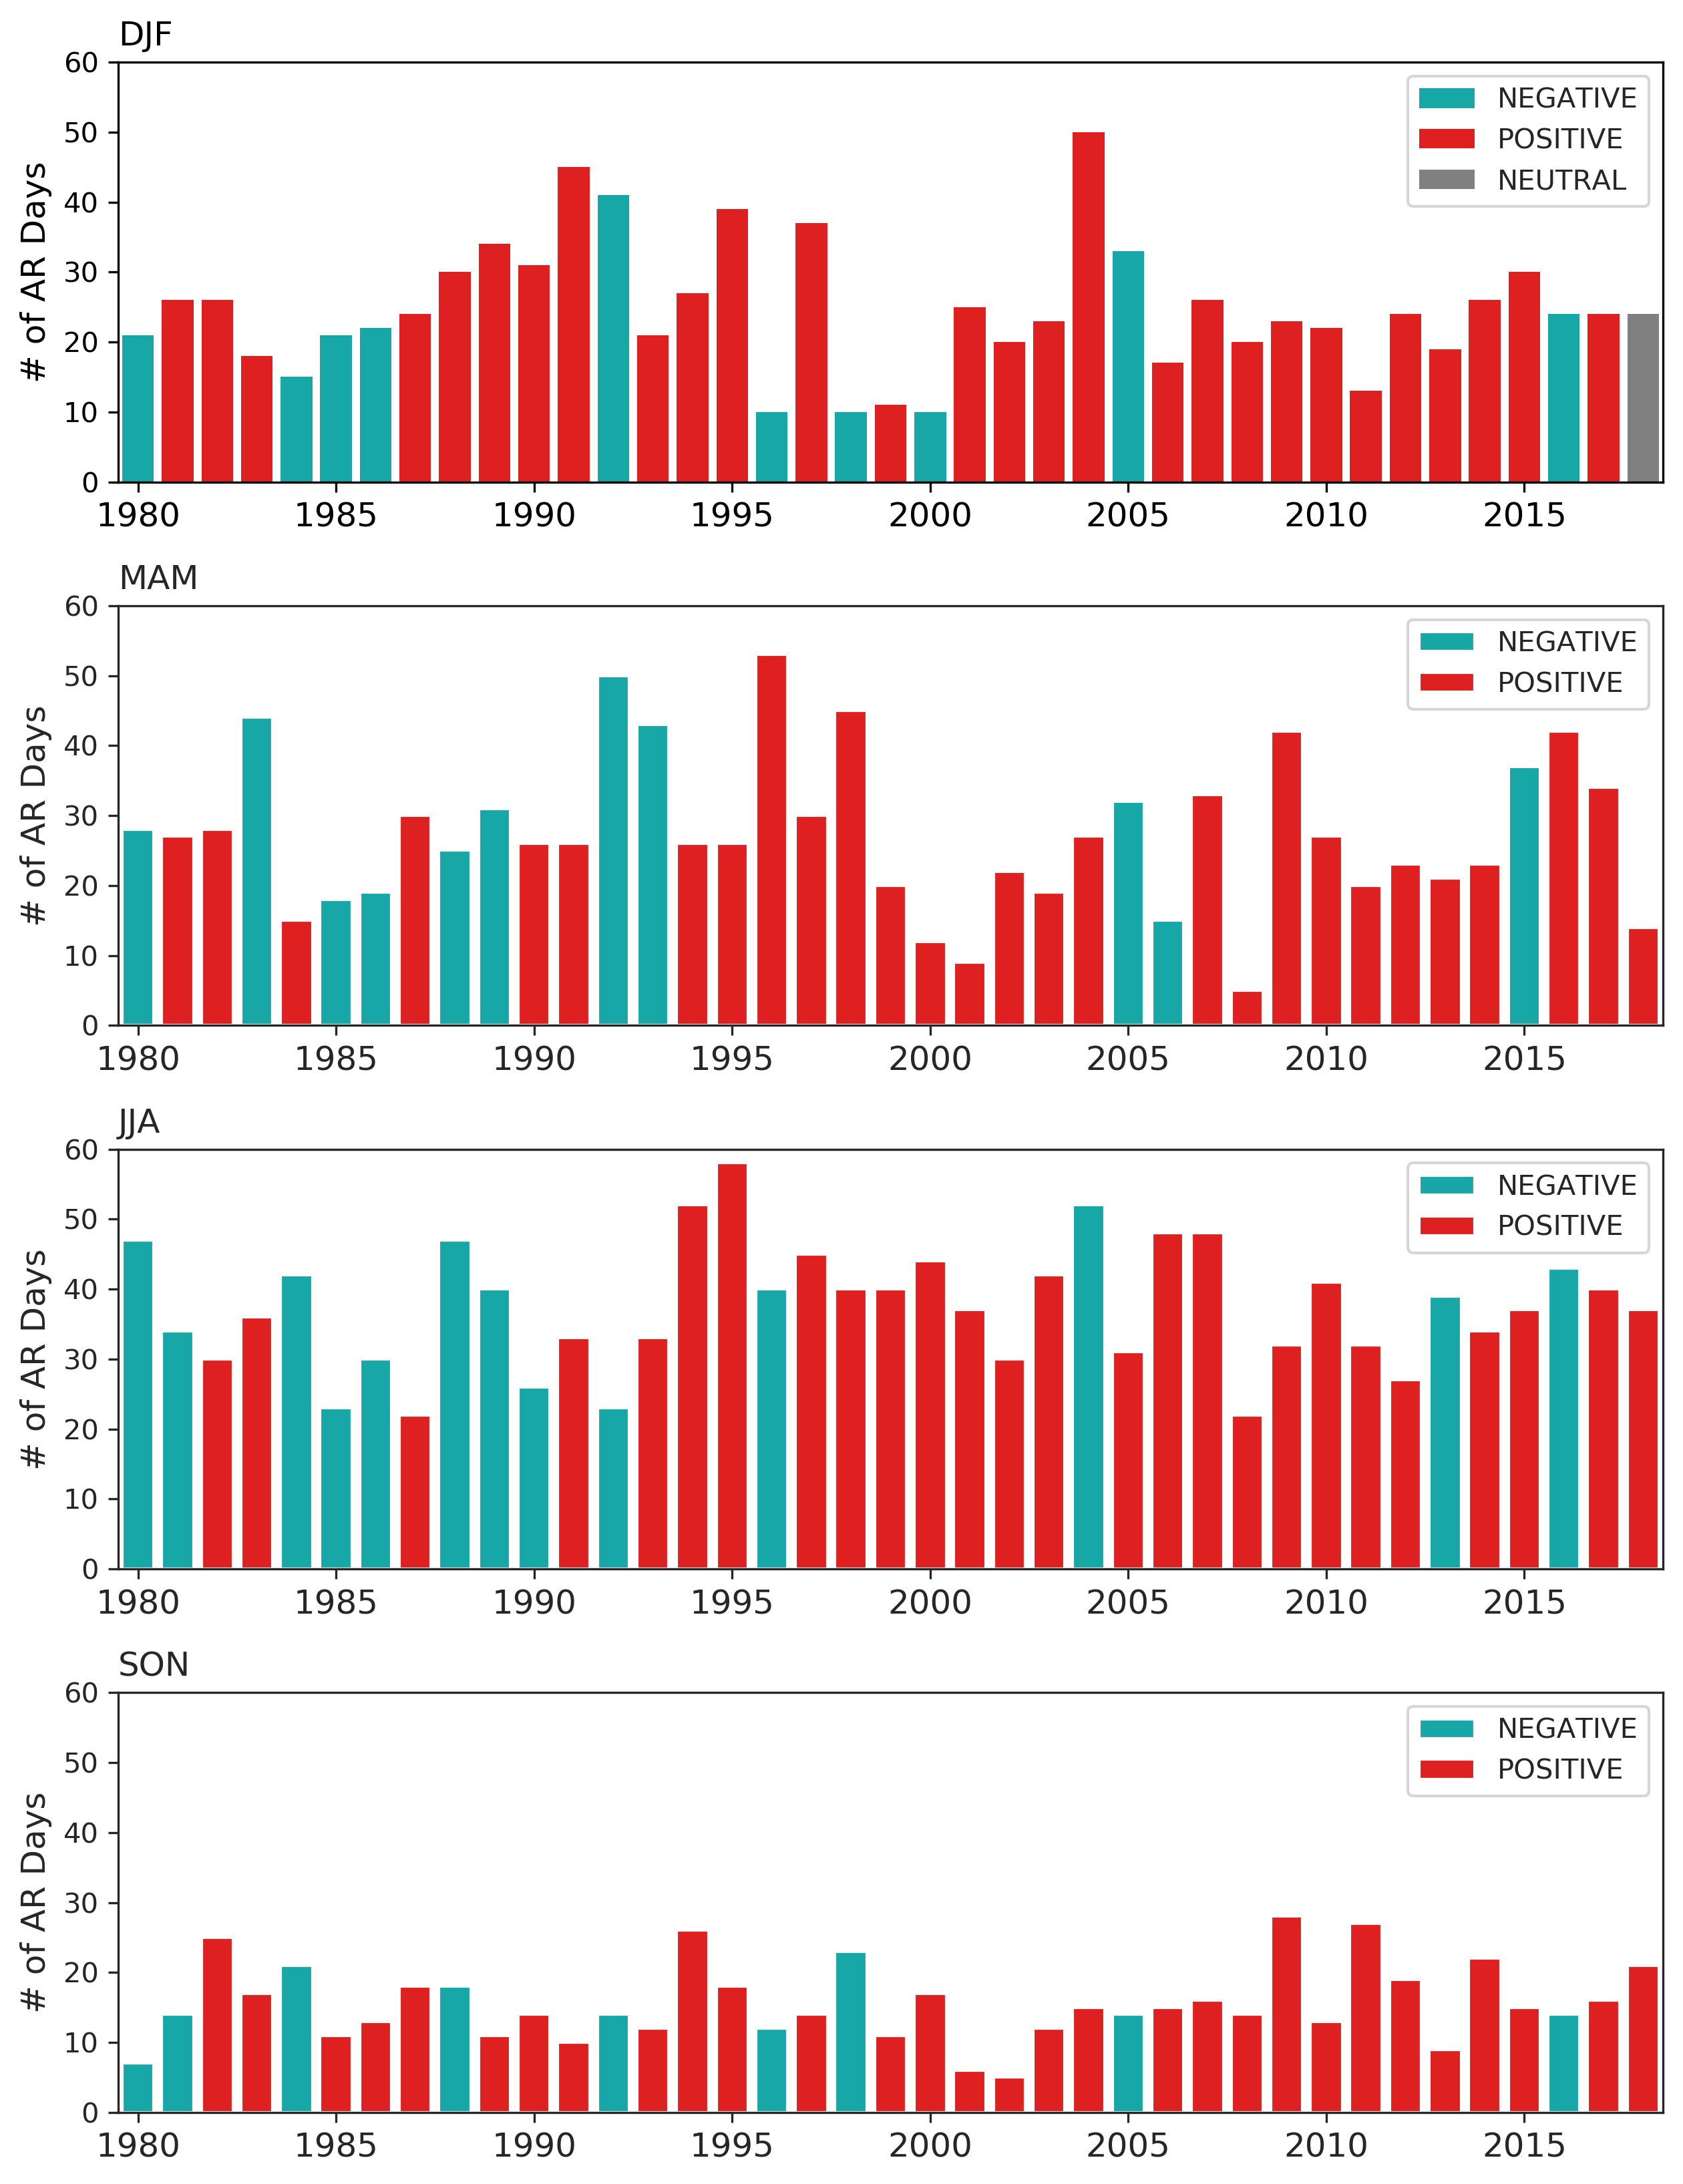

<Figure size 2550x3300 with 0 Axes>

In [5]:
fname = './results/IOD_AR_freq'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,11.0))
fig.dpi = 300
nplots=4

df = [DJF, MAM, JJA, SON]
ssn_label = ['DJF', 'MAM', 'JJA', 'SON']
flatui = ['c', 'red', 'grey']

for i in np.arange(nplots):
    ax = fig.add_subplot(4, 1, i+1)
    data = df[i]
    sns.barplot(x=data.index.year, y='total', hue='COND',
                data=data, palette=flatui, dodge=False)
    sns.set_style("ticks")
    ax.set_ylabel('# of AR Days', fontsize=12)
    ax.set_xlabel('')

    # Format the x axis
    ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
#     ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.set_xticklabels(np.arange(1975, 2020, 5), fontsize=12)
    ax.legend(loc='upper center')
    plt.gca().legend().set_title('')
    plt.ylim(0, 60)
    ax.set_title(ssn_label[i], loc='left')
    
plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [6]:
def _zstat_generic(value1, value2, std_diff, alternative, diff=0):
    '''generic (normal) z-test to save typing

    can be used as ztest based on summary statistics

    '''
    zstat = (value1 - value2 - diff) / std_diff
    if alternative in ['two-sided', '2-sided', '2s']:
        pvalue = stats.norm.sf(np.abs(zstat))*2
    elif alternative in ['larger', 'l']:
        pvalue = stats.norm.sf(zstat)
    elif alternative in ['smaller', 's']:
        pvalue = stats.norm.cdf(zstat)
    else:
        raise ValueError('invalid alternative')
    return zstat, pvalue

def ztest(x1, x2=None, value=0, alternative='two-sided', usevar='pooled',
          ddof=1.):
    '''test for mean based on normal distribution, one or two samples

    In the case of two samples, the samples are assumed to be independent.

    Parameters
    ----------
    x1 : array_like, 1-D or 2-D
        first of the two independent samples
    x2 : array_like, 1-D or 2-D
        second of the two independent samples
    value : float
        In the one sample case, value is the mean of x1 under the Null
        hypothesis.
        In the two sample case, value is the difference between mean of x1 and
        mean of x2 under the Null hypothesis. The test statistic is
        `x1_mean - x2_mean - value`.
    alternative : string
        The alternative hypothesis, H1, has to be one of the following

           'two-sided': H1: difference in means not equal to value (default)
           'larger' :   H1: difference in means larger than value
           'smaller' :  H1: difference in means smaller than value

    usevar : string, 'pooled'
        Currently, only 'pooled' is implemented.
        If ``pooled``, then the standard deviation of the samples is assumed to be
        the same. see CompareMeans.ztest_ind for different options.
    ddof : int
        Degrees of freedom use in the calculation of the variance of the mean
        estimate. In the case of comparing means this is one, however it can
        be adjusted for testing other statistics (proportion, correlation)

    Returns
    -------
    tstat : float
        test statisic
    pvalue : float
        pvalue of the t-test

    Notes
    -----
    usevar not implemented, is always pooled in two sample case
    use CompareMeans instead.

    '''
    #usevar is not used, always pooled

    if usevar != 'pooled':
        raise NotImplementedError('only usevar="pooled" is implemented')

    x1 = np.asarray(x1)
    nobs1 = x1.shape[0]
    x1_mean = x1.mean(0)
    x1_var = x1.var(0)
    if x2 is not None:
        x2 = np.asarray(x2)
        nobs2 = x2.shape[0]
        x2_mean = x2.mean(0)
        x2_var = x2.var(0)
        var_pooled = (nobs1 * x1_var + nobs2 * x2_var)
        var_pooled /= (nobs1 + nobs2 - 2 * ddof)
        var_pooled *= (1. / nobs1 + 1. / nobs2)
    else:
        var_pooled = x1_var / (nobs1 - ddof)
        x2_mean = 0

    std_diff = np.sqrt(var_pooled)
    #stat = x1_mean - x2_mean - value
    return _zstat_generic(x1_mean, x2_mean, std_diff, alternative, diff=value)

def season_zstat(df, season):
    zstat_array = []
    pval_array = []

    s_pos = df.loc[(df['month'] == season) & (df['COND'] == 'POSITIVE')]
    s_neg = df.loc[(new_df['month'] == season) & (df['COND'] == 'NEGATIVE')]
    s_neutral = df.loc[(new_df['month'] == season) & (df['COND'] == 'NEUTRAL')]

    for i, subregion in enumerate(('R01', 'R02', 'R03')):
        zstat, pval = ztest(s_pos[subregion].values, s_neg[subregion].values)
        
        zstat_array.append((zstat))
        pval_array.append((pval))

    return zstat_array, pval_array

In [7]:
DJF_z, DJF_p = season_zstat(new_df, '12')
MAM_z, MAM_p = season_zstat(new_df, '03')
JJA_z, JJA_p = season_zstat(new_df, '06')
SON_z, SON_p = season_zstat(new_df, '09')

In [8]:
arrays = [['IOD Positive - IOD Negative', 'IOD Positive - IOD Negative', 'IOD Positive - IOD Negative'],
           ['R01', 'R02', 'R03']]
index = pd.MultiIndex.from_arrays(arrays, names=('% of AR Days', 'Subregion'))
df2 = pd.DataFrame({'DJF zstat': DJF_z,
                    'DJF pval': DJF_p,
                    'MAM zstat': MAM_z,
                    'MAM pval': MAM_p,
                    'JJA zstat': JJA_z,
                    'JJA pval': JJA_p,
                    'SON zstat': SON_z,
                    'SON pval': SON_p},
                   index=index)
df2

DJF zstat  DJF pval  MAM zstat  \
% of AR Days                Subregion                                   
IOD Positive - IOD Negative R01         0.096072  0.923464   0.213018   
                            R02         1.707755  0.087682  -2.702943   
                            R03         2.094944  0.036176  -1.263255   

                                       MAM pval  JJA zstat  JJA pval  \
% of AR Days                Subregion                                  
IOD Positive - IOD Negative R01        0.831313  -1.737994  0.082212   
                            R02        0.006873  -0.988423  0.322945   
                            R03        0.206498   1.459474  0.144435   

                                       SON zstat  SON pval  
% of AR Days                Subregion                       
IOD Positive - IOD Negative R01         2.291612  0.021928  
                            R02        -2.622506  0.008729  
                            R03        -0.378886  0.704773